In [208]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

import json

In [209]:
# f = open()
data_df = pd.read_json('src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json')


In [210]:
data_df


,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2,timestamp
0,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544,2023-10-19 07:13:00
1,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000,2023-10-19 07:14:00
2,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000,2023-10-19 07:15:00
3,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778,2023-10-19 07:16:00
4,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333,2023-10-19 07:17:00
...,...,...,...,...,...,...,...,...,...
18282,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:55:00
18283,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:56:00
18284,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667,2023-10-31 23:57:00
18285,20.788429,938.428571,11.592286,1.985714,0.575893,31.372857,18.543286,473.928571,2023-10-31 23:58:00


In [211]:
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['timestamp'], unit="ms")) #.sort_index(ascending=True, inplace=False)
data_df = data_df.drop(columns=["timestamp"])



In [212]:
pos = data_df.index[-1]
data_df.loc[pos]

oxygen          20.788429
health         938.428571
dewpt           11.592286
TypPS            1.985714
gauss            0.575893
sound           31.372857
temperature     18.543286
co2            473.928571
Name: 2023-10-31 23:59:00, dtype: float64

In [213]:
train_data_size = int(data_df.shape[0] * 0.6)
df_train = data_df.iloc[:train_data_size]
df_test = data_df.iloc[train_data_size:]

In [214]:
def scale(df):
  scaler = StandardScaler()
  scaler.fit(df)

        # Scale data using the previously defined scaler
  df = pd.DataFrame(scaler.transform(df.copy()), 
                      columns=df.columns, 
                      index=df.index)
  
  return df, scaler


def unscale(df, scaler):
  df = pd.DataFrame(scaler.inverse_transform(df), 
                  columns=df.columns, 
                  index=df.index)
  
  return df

In [215]:
def convert_data_to_stationary(df):
      df_diff = df.copy()
      first_elements = {}

      def check_all_stationarities(df):
        selected_ndiffs_dict = {}
        for i in range(len(df.columns)):
            # stationarity_test_result = test_stationarity_kpss_adf(df[df.columns[i]])
            #is_var_stationary = stationarity_test_result["kpss"]["isStationary"] and stationarity_test_result["adf"]["isStationary"]
            # selected_ndiffs = np.max([stationarity_test_result["kpss"]["ndiffs"], stationarity_test_result["adf"]["ndiffs"]])
            selected_ndiffs_dict[df.columns[i]] = 2#selected_ndiffs

        return selected_ndiffs_dict
      
      selected_ndiffs = check_all_stationarities(df_diff)
      # print(f"Selected ndiffs {selected_ndiffs}")
      # Apply differencing to make data stationary
      # i = 0
      for key, value in selected_ndiffs.items():
          print(f"ndiffs {key} - {value}")
          for i in range(value):
            existing_array = first_elements.get(key, [])
            pos = df_diff[key].index[-1]
            print(f"POSITION > {pos}")          
            first_elements[key] = existing_array + [df_diff.loc[[pos],key]]
            df_diff[key] = df_diff[key].diff()

      max_diff = max(selected_ndiffs.values())
      df_diff = df_diff[max_diff:]

      return df_diff, selected_ndiffs, first_elements



In [216]:
# def inverse_diff(s, last_observation):
#     series_undifferenced = s.copy()

#     series_undifferenced_shifted = pd.concat([last_observation, series_undifferenced], axis=0)

#     series_undifferenced = series_undifferenced_shifted + series_undifferenced_shifted
#     return series_undifferenced

def inverse_diff(s, last_observation):
    series_undifferenced = s.copy()
    series_undifferenced_shifted = pd.concat([last_observation, series_undifferenced], axis=0)
    for i in range(len(series_undifferenced)):
        pos = series_undifferenced.index[i]
        series_undifferenced_shifted[pos] = s.iloc[i]+series_undifferenced_shifted.iloc[i]
    return series_undifferenced_shifted

def df_inv_transformation(pred, diff_order, first_elements):
    df_transformed = pred.copy()
    # df_transformed = pd.DataFrame(scaler.inverse_transform(df_transformed), 
    #                 columns=df_transformed.columns, 
    #                 index=df_transformed.index)
    # print(f"Scaling back diff order {diff_order}")
  
    for key, value in diff_order.items():
        print(f"KEY {key} - VAL {value}")
        for i in range(value):
            print(f"AAAAA var:{key} i:{i} first el:{first_elements[key][-1-i]}")
            df_transformed[key] = inverse_diff(df_transformed[key], first_elements[key][-1-i])

    return df_transformed

In [217]:
df_train_transformed, diff_order, first_elements = convert_data_to_stationary(df_train)
# df_train_transformed, df_train_transformed_scaler = scale(df_train_transformed)

df_testtt = pd.concat([df_train.tail(2), df_test], axis=0) # tail equals hardcoded selected diff
df_test_transformed, d, s = convert_data_to_stationary(df_testtt)
# df_test_transformed, df_test_transformed_scaler = scale(df_test_transformed)
df_test_transformed

ndiffs oxygen - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs health - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs dewpt - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs TypPS - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs gauss - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs sound - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs temperature - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs co2 - 2
POSITION > 2023-10-26 22:04:00
POSITION > 2023-10-26 22:04:00
ndiffs oxygen - 2
POSITION > 2023-10-31 23:59:00
POSITION > 2023-10-31 23:59:00
ndiffs health - 2
POSITION > 2023-10-31 23:59:00
POSITION > 2023-10-31 23:59:00
ndiffs dewpt - 2
POSITION > 2023-10-31 23:59:00
POSITION > 2023-10-31 23:59:00
ndiffs TypPS - 2
POSITION > 2023-10-31 23:59:00
POSITION > 2023-10-31 23:59:00
ndiffs gauss - 2
POSITION > 2023-10-31 23:59

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,-0.010167,-56.666667,-0.005167,1.708333,0.208995,0.147500,-0.002667,1.225025
2023-10-26 22:06:00,0.005250,17.250000,0.002250,-0.750000,-0.089408,0.005000,0.000250,-2.625013
2023-10-26 22:07:00,-0.000333,28.500000,0.001333,-0.291667,-0.041432,0.157500,0.001500,-1.558367
2023-10-26 22:08:00,-0.004333,-43.954545,-0.001848,0.021970,0.076023,-0.330227,-0.002682,1.891733
2023-10-26 22:09:00,0.004667,15.454545,0.000515,0.269697,-0.034591,0.172727,0.001182,-0.333367
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,-0.001218,6.218182,0.006727,0.474545,0.154392,0.231273,0.003055,1.120000
2023-10-31 23:56:00,0.001218,-6.218182,-0.006727,-0.474545,-0.154392,-0.231273,-0.003055,-1.120000
2023-10-31 23:57:00,-0.000600,30.266667,-0.005000,-0.603333,-0.062846,-0.117333,0.000567,-0.503333


In [218]:
# df_test_transformed = unscale(df_test_transformed, df_test_transformed_scaler)
df_forecast_original = df_inv_transformation(df_test_transformed, diff_order, first_elements)


KEY oxygen - VAL 2
AAAAA var:oxygen i:0 first el:timestamp
2023-10-26 22:04:00    0.004917
Name: oxygen, dtype: float64
AAAAA var:oxygen i:1 first el:timestamp
2023-10-26 22:04:00    20.78625
Name: oxygen, dtype: float64
KEY health - VAL 2
AAAAA var:health i:0 first el:timestamp
2023-10-26 22:04:00    39.416667
Name: health, dtype: float64
AAAAA var:health i:1 first el:timestamp
2023-10-26 22:04:00    962.75
Name: health, dtype: float64
KEY dewpt - VAL 2
AAAAA var:dewpt i:0 first el:timestamp
2023-10-26 22:04:00    0.002917
Name: dewpt, dtype: float64
AAAAA var:dewpt i:1 first el:timestamp
2023-10-26 22:04:00    12.64425
Name: dewpt, dtype: float64
KEY TypPS - VAL 2
AAAAA var:TypPS i:0 first el:timestamp
2023-10-26 22:04:00   -0.958333
Name: TypPS, dtype: float64
AAAAA var:TypPS i:1 first el:timestamp
2023-10-26 22:04:00    1.475
Name: TypPS, dtype: float64
KEY gauss - VAL 2
AAAAA var:gauss i:0 first el:timestamp
2023-10-26 22:04:00   -0.119586
Name: gauss, dtype: float64
AAAAA var:gau

In [219]:
df_forecast_original.head(10)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.011000,711.683333
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.015222,709.977767


In [220]:
df_test.head(20)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.011000,711.683333
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.015222,709.977767


<Axes: xlabel='timestamp'>

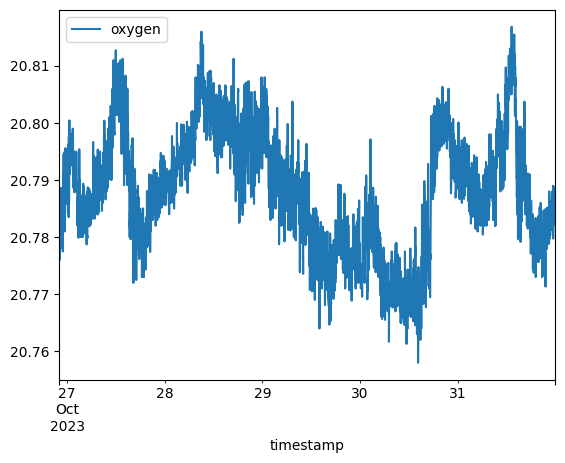

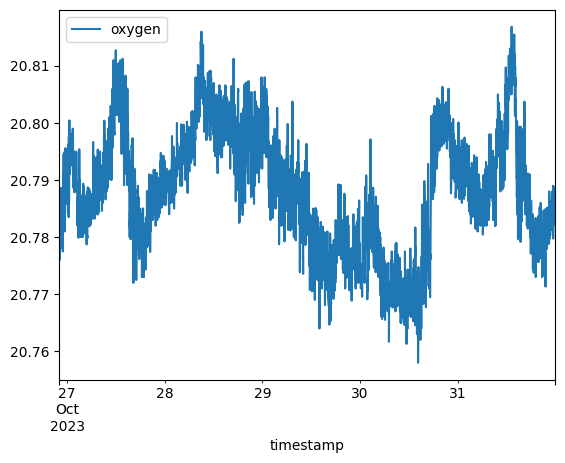

In [221]:
df_forecast_original.plot( y='oxygen')
df_test.plot( y='oxygen')

<Axes: xlabel='timestamp'>

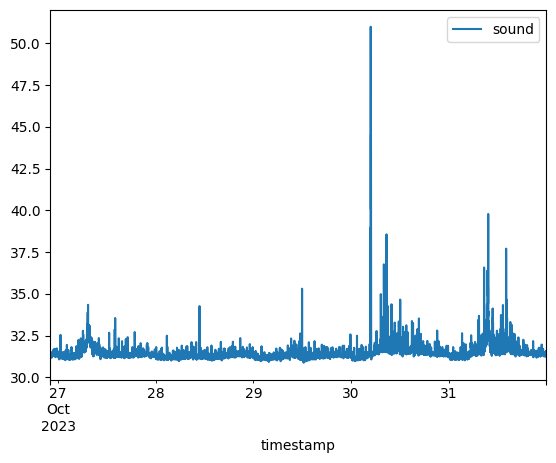

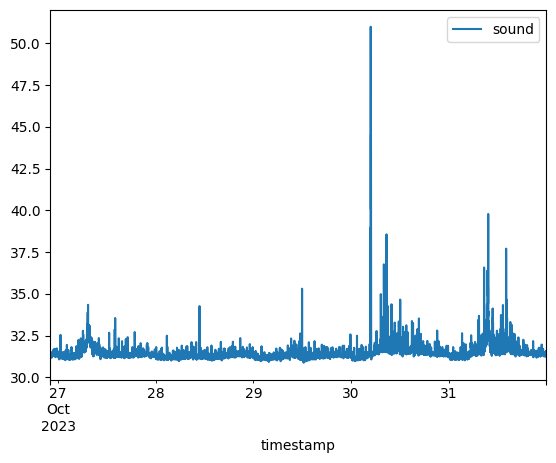

In [222]:
df_forecast_original.plot( y='sound')
df_test.plot( y='sound')

<Axes: xlabel='timestamp'>

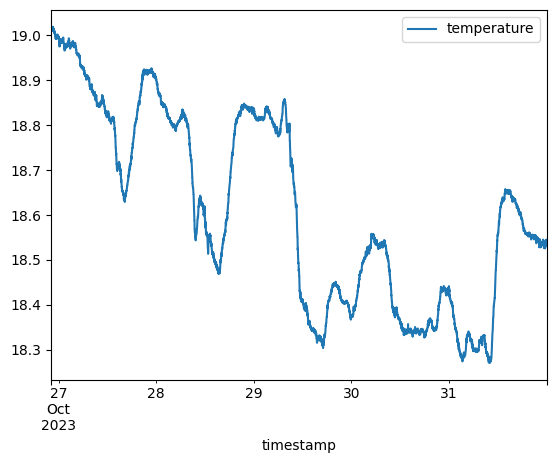

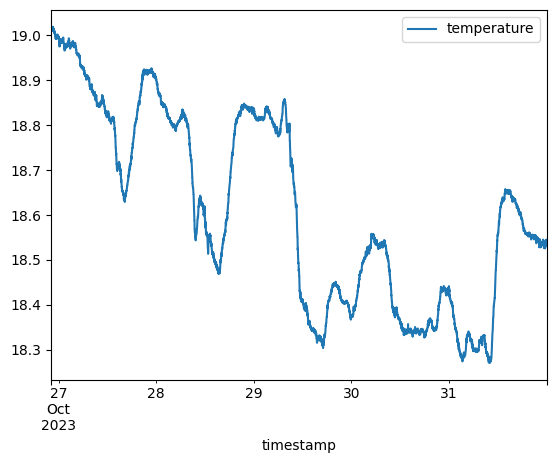

In [223]:
df_forecast_original.plot( y='temperature')
df_test.plot( y='temperature')

In [224]:
my_range[~my_range.isin(data_df.index)]

NameError: name 'my_range' is not defined

In [ ]:
data_df.size

In [ ]:
data_df.duplicated().value_counts()
data_df = data_df.drop_duplicates()



In [ ]:
data_df.size

In [ ]:
data_df_1m = data_df.groupby(pd.Grouper(key='timestamp', freq='1min')).mean()

In [ ]:
data_df_1m

In [ ]:
df_filled = data_df_1m.bfill()

In [ ]:
df_filled

In [ ]:
my_range_in1m = pd.date_range(start=df_filled.index.min(), end=df_filled.index.max(), freq='1min')


In [ ]:
len(my_range_in1m[~my_range_in1m.isin(df_filled.index)])


In [ ]:
df_filled["timestamp"] = df_filled.index

In [ ]:
df_filled.to_json('./src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json', orient="records")

In [ ]:
grouped = data_df.groupby('Entity')

In [ ]:
data_df['Entity'].unique()

In [ ]:
data_df = data_df[data_df["Entity"] == 'Austria']

In [ ]:
data_df

In [ ]:
data_df.isna().sum()

In [ ]:
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df["Day"])) #.sort_index(ascending=True, inplace=False)


In [ ]:
data_df

In [ ]:
my_range = pd.date_range(start=data_df['Day'].min(), end=data_df['Day'].max(), freq='D')


In [ ]:
len(my_range[~my_range.isin(data_df.index)])


In [ ]:
my_range.drop_duplicates()

In [ ]:
print(data_df.shape)
new_df = pd.DataFrame()
new_df.index = my_range
new_df["Day"] = my_range
data_df = pd.merge(data_df, new_df, how="outer", right_index=True, left_index=True, validate="many_to_many")

In [ ]:
data_df.index.drop_duplicates()
print(data_df)


In [ ]:
data_df = data_df.groupby(data_df.index).last()

In [ ]:
data_df = data_df.drop_duplicates(keep='last')

In [ ]:
print(f"Duplicates: {data_df.index.duplicated()}")


In [ ]:
data_df = data_df.drop(columns=['Day_x', 'Day_y'])


In [ ]:
data_df["Day"] = data_df.index

In [ ]:
data_df.isna().sum()

In [ ]:
data_df = data_df.fillna(0)

In [ ]:
data_df

In [ ]:
data_df1 = pd.read_csv('src/api/data/weekly-covid-deaths.csv')

In [ ]:
grouped = data_df1.groupby('Entity')


In [ ]:
data_df1 = data_df1[data_df1["Entity"] == 'Austria']

In [ ]:
data_df1.isna().sum()

In [ ]:
data_df1.index = pd.DatetimeIndex(pd.to_datetime(data_df1["Day"])) #.sort_index(ascending=True, inplace=False)


In [ ]:
data_df = data_df.drop(columns=['Entity', 'Code'])
data_df

In [ ]:
data_df1 = data_df1.drop(columns=['Entity', 'Code'])
data_df1

In [ ]:
joint = data_df.join(data_df1, how='inner', on="Day")

In [ ]:
joint

In [ ]:
joint["timestamp"] = joint.index

In [ ]:
joint.to_json('./src/api/data/non-cumulative-deaths-and-cases-covid_14-08-24_Austria.json', orient="records")